MEG sensor level analysis code for the project of "dynamic flow";
22th Oct by Bohao;
Steps of code:
1.Import data, plot data and check;
2.Max-filter to remove big artifacts;
3.Band pass filering, plot data and do annotations on bad segments and channels;
4.Load annotated data and check PSD plots;
5.Check events plot;
6.Apply empty-room recording SSP to denoise;
7.Apply cHPI to correct head movement
8.Concatenate three data files
9.Compute ICA;
10.Apply ICA and check the ICA-ed data;
11.Load ICA-ed data and Segment data;
12.Plot ERF for each type of sounds;
13.Calculating significant sensors with permutation test;
14.View the significant sensors on topography;
15.View the significant sensors on surface (with sMRI data)


In [1]:
import mne
import os
import numpy as np
import picard
mne.viz.set_browser_backend('qt')
from mne import annotations_from_events
import matplotlib.pyplot as plt
from mne.stats import permutation_t_test
from mne.preprocessing import maxwell_filter
n_jobs = os.cpu_count()

Using qt as 2D backend.


In [3]:
# 1. import data, plot data and check, if big artifacts exist, go 2, otherwise go 3
subject         = 'test'
DDIR            = 'D:/Ph.D/11_unige/MEG/' # change this for your computer
meg_file        = f'{DDIR}/MEGdata/{subject}/test_pilot_nodevice.fif' #only conducting oddball task
raw = mne.io.read_raw_fif(meg_file, allow_maxshield=True, preload=True, verbose=True)
raw.plot()

Opening raw data file D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_nodevice.fif...
    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 12000 ... 230999 =     12.000 ...   230.999 secs
Ready.
Reading 0 ... 218999  =      0.000 

C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_26924\910110612.py:5: RuntimeWarning: This filename (D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_nodevice.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(meg_file, allow_maxshield=True, preload=True, verbose=True)


Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [4]:
# 2. Max-filter to remove big artifacts
if raw.info['proc_history'] == []:
    head_pos = None
    calibration = f'{DDIR}/MEGdata/needed file/sss_cal.dat' # file from FCBG
    cross_talk = f'{DDIR}/MEGdata/needed file/ct_sparse.fif'# file from FCBG
    raw_filtered = maxwell_filter(raw, origin='auto', int_order=8, ext_order=3, 
                                  calibration=calibration, cross_talk=cross_talk, st_duration=10.0,
                                  st_correlation=0.98, coord_frame='head', destination=None, 
                                  regularize='in', ignore_ref=False, bad_condition='error', 
                                  head_pos=head_pos, st_fixed=True, st_only=False, mag_scale=100.0, 
                                  skip_by_annotation=('edge', 'bad_acq_skip'), 
                                  extended_proj=(), verbose=True)
del raw
raw=raw_filtered
raw.plot()

Maxwell filtering raw data
    No bad MEG channels
    Processing 204 gradiometers and 102 magnetometers
    Using fine calibration sss_cal.dat
        Adjusting non-orthogonal EX and EY
        Adjusted coil positions by (μ ± σ): 0.4° ± 0.4° (max: 2.0°)
    Automatic origin fit: head of radius 90.5 mm
    Using origin -1.1, 6.5, 42.7 mm in the head frame
    Processing data using tSSS with st_duration=10.0
        Using 87/95 harmonic components for    0.000  (72/80 in, 15/15 out)
    Using loaded raw data
    Spatiotemporal window did not fit evenly intocontiguous data segment. 9.00 seconds were lumped into the previous window.
    Processing 21 data chunks
        Projecting  0 intersecting tSSS components for    0.000 -    9.999 s  (#1/21)
        Projecting  0 intersecting tSSS components for   10.000 -   19.999 s  (#2/21)
        Projecting  1 intersecting tSSS component  for   20.000 -   29.999 s  (#3/21)
        Projecting  1 intersecting tSSS component  for   30.000 -   39.999

In [5]:
# 3. Band pass filering, plot data and do annotations on bad segments and channels (with the label "bad")
raw.filter(0.5, 40.0)
raw.plot()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    2.2s


Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [6]:
# 3.1 save the annotated data
dir_name, file_name = os.path.split(raw.filenames[0])
base_name, ext = os.path.splitext(file_name)
new_file_name = f"{base_name}_annotated{ext}"
save_path = os.path.join(dir_name, new_file_name)
raw.save(save_path, overwrite=True)

Overwriting existing file.
Writing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated.fif


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_26924\3434116997.py:6: RuntimeWarning: This filename (D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_annotated.fif
[done]


Opening raw data file D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_withdevice_annotated.fif...
    Range : 33000 ... 316999 =     33.000 ...   316.999 secs
Ready.
Reading 0 ... 283999  =      0.000 ...   283.999 secs...


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_10052\154279399.py:5: RuntimeWarning: This filename (D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_withdevice_annotated.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(meg_file, allow_maxshield=True, preload=True, verbose=True)


Setting 18000 of 284000 (6.34%) samples to NaN, retaining 266000 (93.66%) samples.
Effective window size : 2.048 (s)


c:\Users\Bohao Tian\AppData\Local\Programs\Python\Python38\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


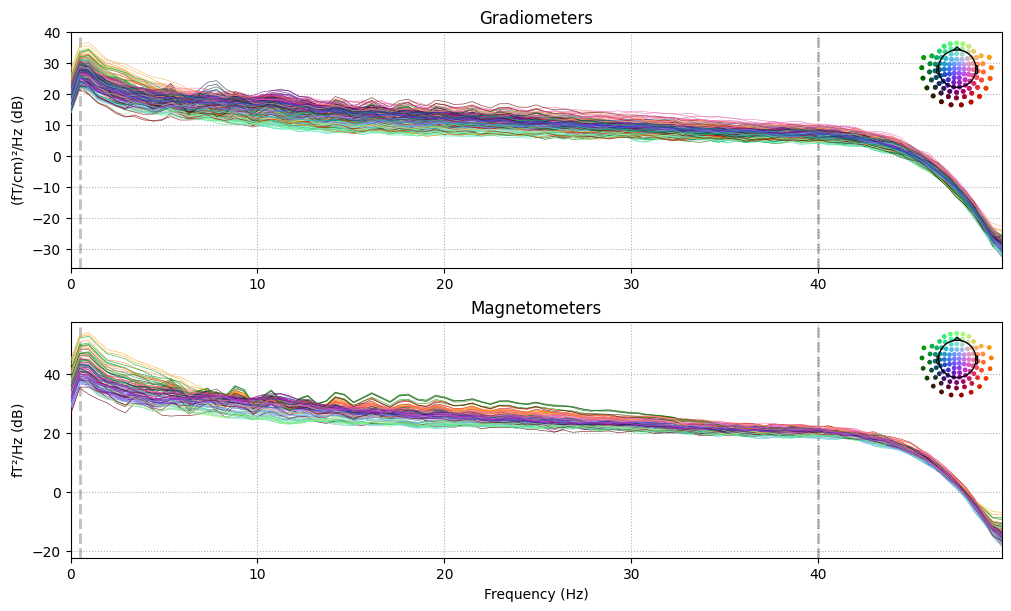

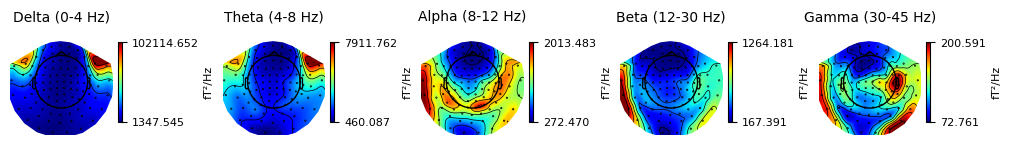

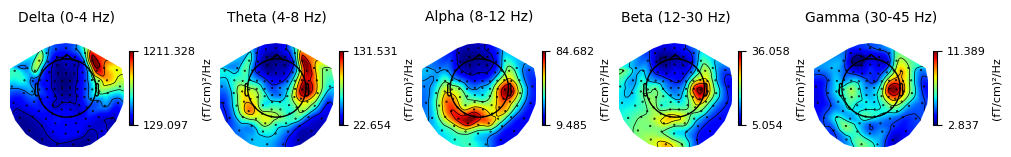

In [21]:
# 4. Load annotated data and check PSD plots 
subject         = 'test'
DDIR            = 'D:/Ph.D/11_unige/MEG/' # change this for your computer
meg_file        = f'{DDIR}/MEGdata/{subject}/test_pilot_nodevice_annotated.fif'
raw = mne.io.read_raw_fif(meg_file, allow_maxshield=True, preload=True, verbose=True)
psd_raw  = raw.compute_psd(fmax=50)
psd_raw.plot(xscale='linear')
#psd_raw.plot_topo(color='k', fig_facecolor='w', axis_facecolor='w', axes=None, block=False, show=True)
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}
for ch_type in set(['eeg','mag','grad']).intersection(np.unique(raw.get_channel_types()).tolist()):
    psd_raw.plot_topomap(bands=bands, ch_type=ch_type, cmap='jet')

200 events found on stim channel STI102
Event IDs: [16 32 64]


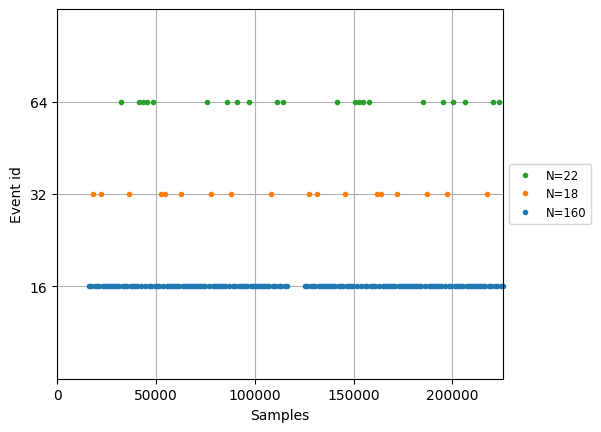

Waiting for Loading-Thread to finish... (max. 10 sec)
Channels marked as bad:
none


In [7]:
# 5. Check events plot
events = mne.find_events(raw, stim_channel="STI102")
mne.viz.plot_events(events, first_samp=0, equal_spacing=True, show=True)   
raw.plot(
    events=events,
    event_color={16: "r", 32: "g", 64: "b"},
)  

In [8]:
# 6. Apply empty-room SSP to denoise
fname = f'{DDIR}/MEGdata/needed file/test_empty_room_device_raw.fif' # recorded on Oct 8th 2024, not from FCBG, with pressing device on
raw_empty = mne.io.read_raw_fif(fname, preload=True)
raw_empty.apply_proj().filter(0.5, 40.0)
noise_cov = mne.compute_raw_covariance(raw_empty)
projs = mne.compute_proj_raw(raw_empty, n_grad=2, n_mag=2, n_eeg=0)
raw.add_proj(projs)
raw.apply_proj()

Opening raw data file D:/Ph.D/11_unige/MEG//MEGdata/needed file/test_empty_room_device_raw.fif...
Isotrak not found
    Read a total of 17 projection items:
        ssp_combined_0_68deg (1 x 306)  idle
        ssp_combined_1_68deg (1 x 306)  idle
        ssp_combined_2_68deg (1 x 306)  idle
        ssp_combined_3_68deg (1 x 306)  idle
        ssp_combined_4_68deg (1 x 306)  idle
        ssp_combined_5_68deg (1 x 306)  idle
        ssp_combined_6_68deg (1 x 306)  idle
        ssp_combined_7_68deg (1 x 306)  idle
        ssp_combined_8_68deg (1 x 306)  idle
        ssp_combined_9_68deg (1 x 306)  idle
        ssp_combined_10_68deg (1 x 306)  idle
        ssp_combined_11_68deg (1 x 306)  idle
        ssp_combined_12_68deg (1 x 306)  idle
        ssp_combined_13_68deg (1 x 306)  idle
        ssp_combined_14_68deg (1 x 306)  idle
        ssp_combined_15_68deg (1 x 306)  idle
        ssp_combined_16_68deg (1 x 306)  idle
    Range : 2000 ... 149999 =      2.000 ...   149.999 secs
Ready.
Read

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.7s


Using up to 740 segments


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    1.4s


Number of samples used : 148000
[done]
Not setting metadata
148 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 17)
17 projection items activated


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s


Adding projection: planar-Raw-0.000-148.000-PCA-01
Adding projection: planar-Raw-0.000-148.000-PCA-02
Adding projection: axial-Raw-0.000-148.000-PCA-01
Adding projection: axial-Raw-0.000-148.000-PCA-02
No channels 'eeg' found. Skipping.
4 projection items deactivated
Created an SSP operator (subspace dimension = 4)
4 projection items activated
SSP projectors applied...


<Raw | test_pilot_nodevice.fif, 320 x 219000 (219.0 s), ~541.2 MB, data loaded>

In [ ]:
# 7. Apply cHPI to correct head movement 
# (now we don't have)

In [ ]:
# 8. Concatenate three data files
# (now we don't have)

<ICA | no decomposition, method: picard>
Fitting ICA to data using 306 channels (please be patient, this may take a while)


    Applying projection operator with 4 vectors (pre-whitener computation)
    Applying projection operator with 4 vectors (pre-whitener application)
Selecting by number: 30 components
    Applying projection operator with 4 vectors (pre-whitener application)
Fitting ICA took 33.4s.
<ICA | raw data decomposition, method: picard (fit in 110 iterations on 219000 samples), 30 ICA components (306 PCA components available), channel types: mag, grad, no sources marked for exclusion>


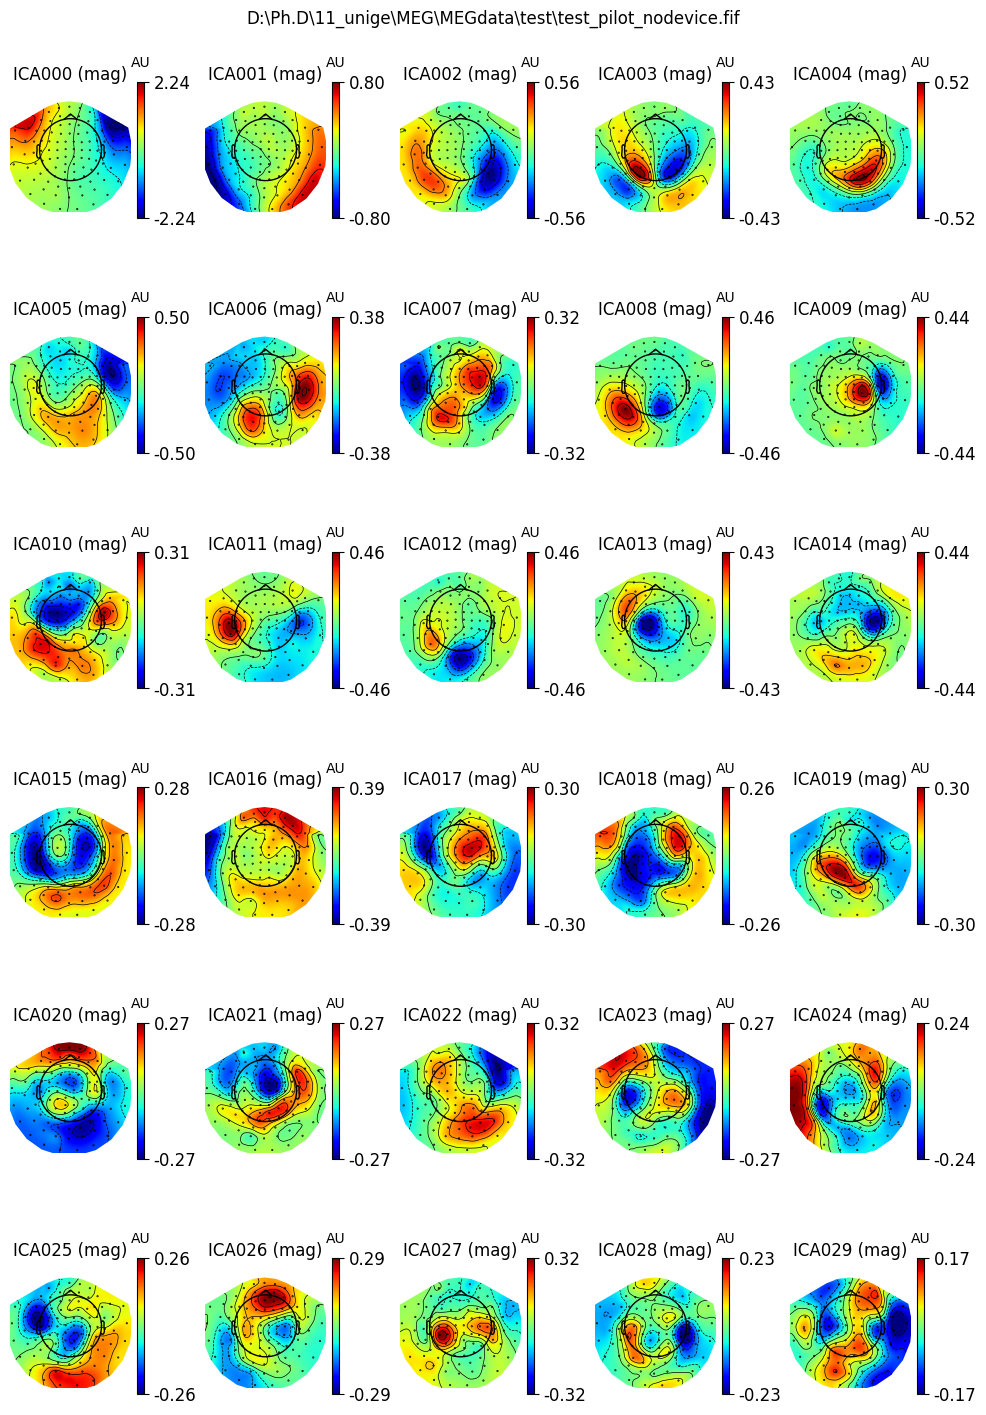

    Applying projection operator with 4 vectors (pre-whitener application)
Creating RawArray with float64 data, n_channels=30, n_times=219000
    Range : 12000 ... 230999 =     12.000 ...   230.999 secs
Ready.
Applying ICA to Raw instance
    Applying projection operator with 4 vectors (pre-whitener application)
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 306 PCA components


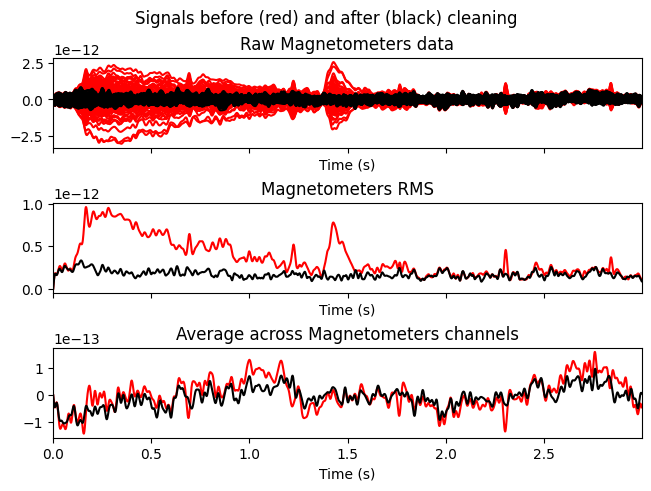

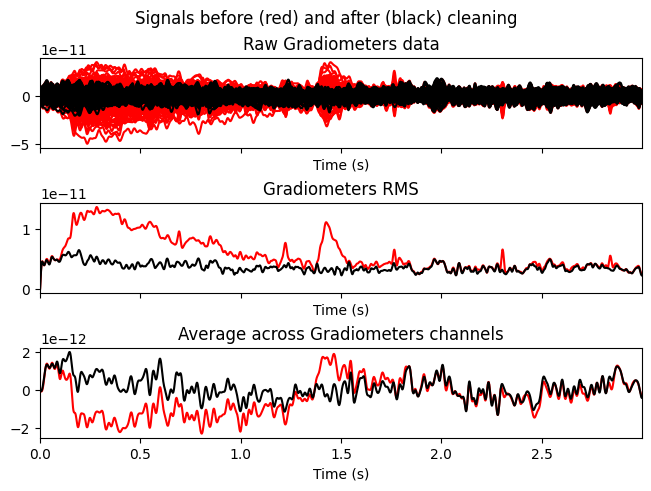

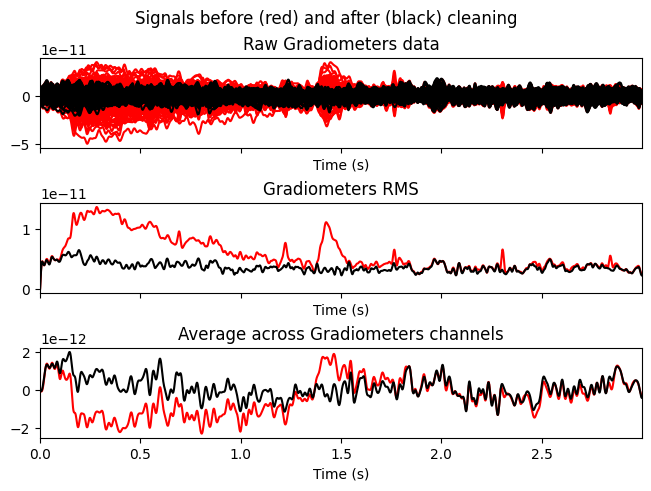

In [9]:
# 9. Computing ICAs
percentcut_bothside, n_components, method, decim = 5, 30, 'picard', 1
ica = mne.preprocessing.ICA(n_components=n_components, method=method)
print(ica)
ica.fit(raw, picks=None, start=None, stop=None, 
          decim=decim, reject=None, reject_by_annotation=True, flat=None, verbose=True)
print(ica)
ica.plot_components(picks=range(0, ica.n_components_), ch_type=None, res=64, 
              cmap='jet', sensors=True, colorbar=True, title=raw.filenames[0].split('/')[-1], show=True, 
              outlines='head', contours=8, image_interp='cubic', inst=None)  
ica.plot_sources(raw, block=True)
ica.plot_overlay(raw)

Components to Exclude = [0, 1, 16]
<ICA | raw data decomposition, method: picard (fit in 110 iterations on 219000 samples), 30 ICA components (306 PCA components available), channel types: mag, grad, 3 sources marked for exclusion>
Applying ICA to Raw instance
    Applying projection operator with 4 vectors (pre-whitener application)
    Transforming to ICA space (30 components)
    Zeroing out 3 ICA components
    Projecting back using 306 PCA components
Effective window size : 2.048 (s)


c:\Users\Bohao Tian\AppData\Local\Programs\Python\Python38\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


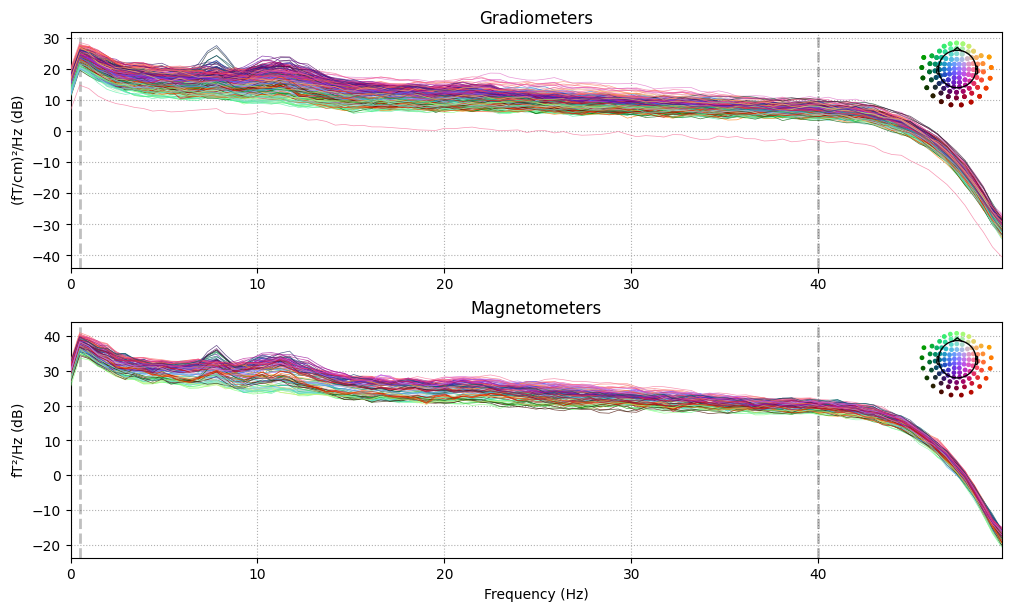

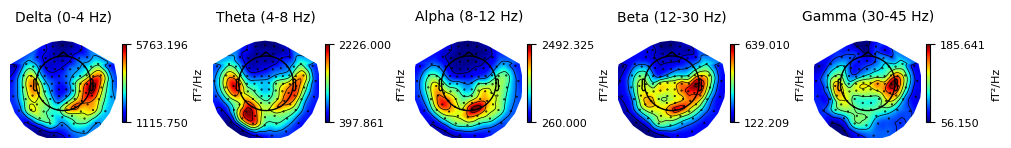

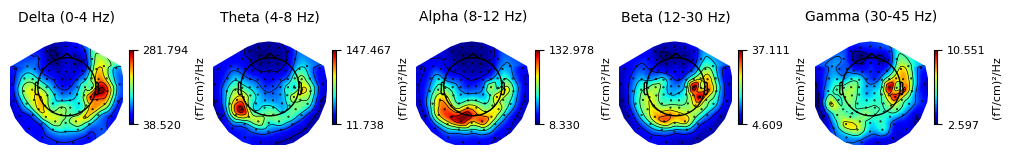

Channels marked as bad:
none


In [10]:
# 10. Apply ICA and check the ICA-ed data
print("Components to Exclude = %s" % ica.exclude)
print(ica)
ica.apply(raw)
raw.plot()
psd_raw  = raw.compute_psd(fmax=50)
psd_raw.plot(xscale='linear')
bands = {'Delta (0-4 Hz)': (0, 4), 'Theta (4-8 Hz)': (4, 8),
         'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30),
         'Gamma (30-45 Hz)': (30, 45)}
for ch_type in set(['eeg','mag','grad']).intersection(np.unique(raw.get_channel_types()).tolist()):
    psd_raw.plot_topomap(bands=bands, ch_type=ch_type, cmap='jet')

In [11]:
# 10.1 save ICA-ed data
dir_name, file_name = os.path.split(raw.filenames[0])
base_name, ext = os.path.splitext(file_name)
new_file_name = f"{base_name}_ICAed{ext}"
save_path = os.path.join(dir_name, new_file_name)
raw.save(save_path, overwrite=True)

Writing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_ICAed.fif


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_26924\1115595427.py:6: RuntimeWarning: This filename (D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_ICAed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(save_path, overwrite=True)


Closing D:\Ph.D\11_unige\MEG\MEGdata\test\test_pilot_nodevice_ICAed.fif
[done]


In [12]:
# 11. Load ICA-ed data and Segment data (with baseline correction)
subject         = 'test'
DDIR            = 'D:/Ph.D/11_unige/MEG/' # change this for your computer
meg_file        = f'{DDIR}/MEGdata/{subject}/test_pilot_nodevice_annotated_ICAed.fif' # the ICA-ed data file
raw = mne.io.read_raw_fif(meg_file, allow_maxshield=True, preload=True, verbose=True)
events = mne.find_events(raw, stim_channel="STI102")
event_id = {
    "auditory/standard": 16,
    "auditory/target": 32,
    "auditory/novel": 64,
}
epochs = mne.Epochs(
    raw, events, event_id, tmin=-0.2, tmax=0.6, baseline=(-0.2, 0), picks="meg", preload=True
)

Opening raw data file D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_nodevice_annotated_ICAed.fif...
    Read a total of 4 projection items:
        planar-Raw-0.000-148.000-PCA-01 (1 x 204) active
        planar-Raw-0.000-148.000-PCA-02 (1 x 204) active
        axial-Raw-0.000-148.000-PCA-01 (1 x 102) active
        axial-Raw-0.000-148.000-PCA-02 (1 x 102) active
    Range : 12000 ... 230999 =     12.000 ...   230.999 secs
Ready.
Reading 0 ... 218999  =      0.000 ...   218.999 secs...


C:\Users\Bohao Tian\AppData\Local\Temp\ipykernel_26924\1585779507.py:5: RuntimeWarning: This filename (D:/Ph.D/11_unige/MEG//MEGdata/test/test_pilot_nodevice_annotated_ICAed.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(meg_file, allow_maxshield=True, preload=True, verbose=True)


200 events found on stim channel STI102
Event IDs: [16 32 64]
Not setting metadata
200 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Using data from preloaded Raw for 200 events and 801 original time points ...
2 bad epochs dropped


Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-01, active : True, n_channels : 204, exp. var : 6.39%>
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-02, active : True, n_channels : 204, exp. var : 4.17%>


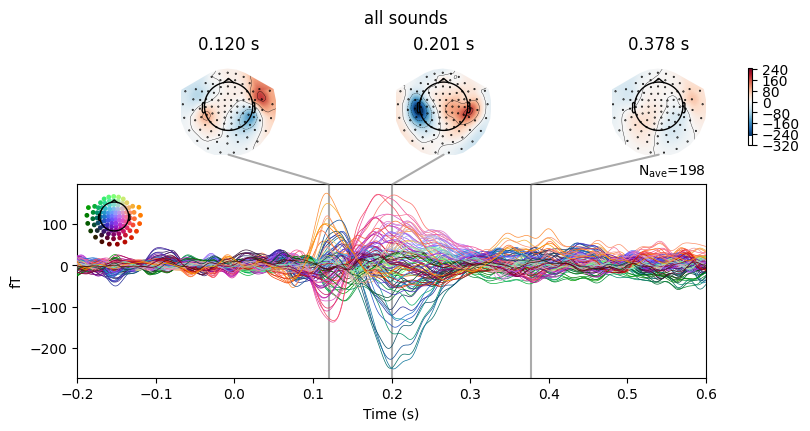

Removing projector <Projection | axial-Raw-0.000-148.000-PCA-01, active : True, n_channels : 102, exp. var : 24.82%>
Removing projector <Projection | axial-Raw-0.000-148.000-PCA-02, active : True, n_channels : 102, exp. var : 19.43%>


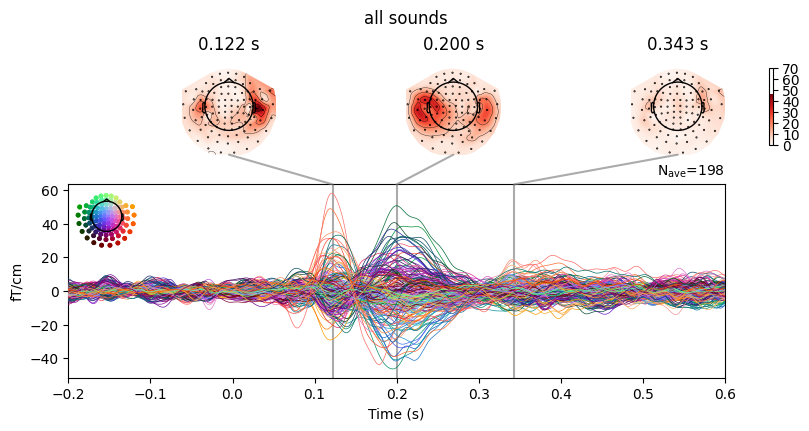

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-01, active : True, n_channels : 204, exp. var : 6.39%>
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-02, active : True, n_channels : 204, exp. var : 4.17%>


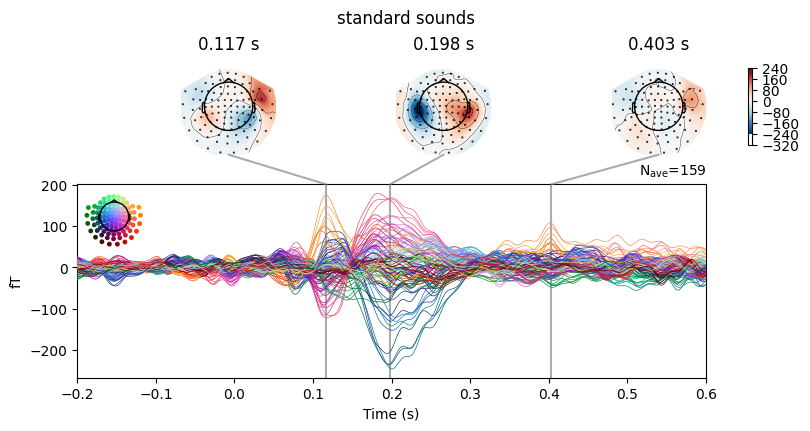

Removing projector <Projection | axial-Raw-0.000-148.000-PCA-01, active : True, n_channels : 102, exp. var : 24.82%>
Removing projector <Projection | axial-Raw-0.000-148.000-PCA-02, active : True, n_channels : 102, exp. var : 19.43%>


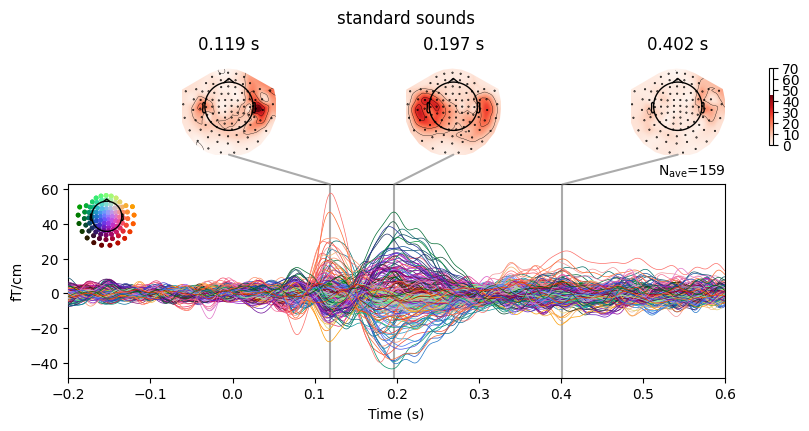

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-01, active : True, n_channels : 204, exp. var : 6.39%>
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-02, active : True, n_channels : 204, exp. var : 4.17%>


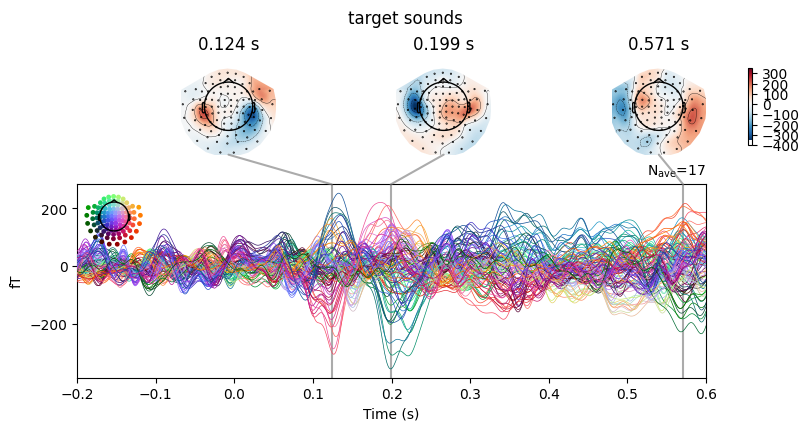

Removing projector <Projection | axial-Raw-0.000-148.000-PCA-01, active : True, n_channels : 102, exp. var : 24.82%>
Removing projector <Projection | axial-Raw-0.000-148.000-PCA-02, active : True, n_channels : 102, exp. var : 19.43%>


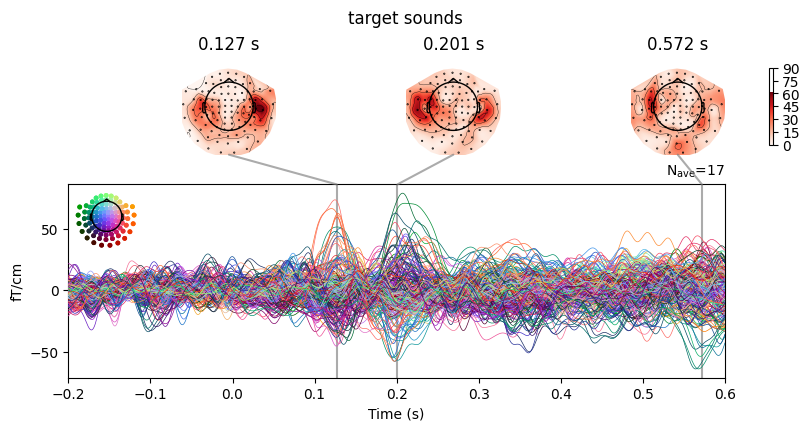

Projections have already been applied. Setting proj attribute to True.
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-01, active : True, n_channels : 204, exp. var : 6.39%>
Removing projector <Projection | planar-Raw-0.000-148.000-PCA-02, active : True, n_channels : 204, exp. var : 4.17%>


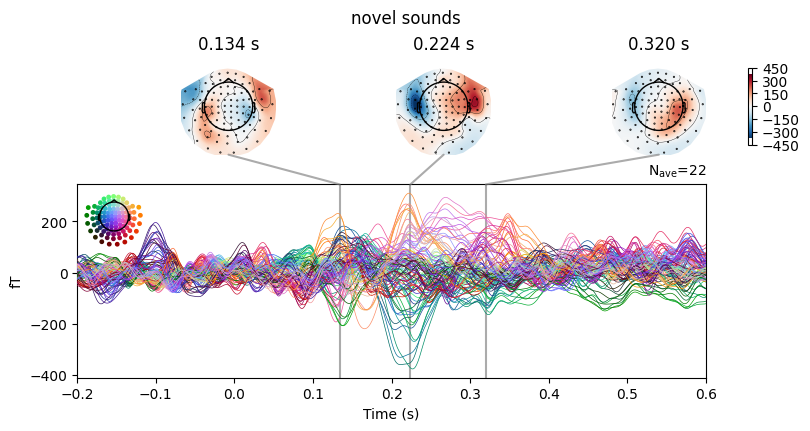

Removing projector <Projection | axial-Raw-0.000-148.000-PCA-01, active : True, n_channels : 102, exp. var : 24.82%>
Removing projector <Projection | axial-Raw-0.000-148.000-PCA-02, active : True, n_channels : 102, exp. var : 19.43%>


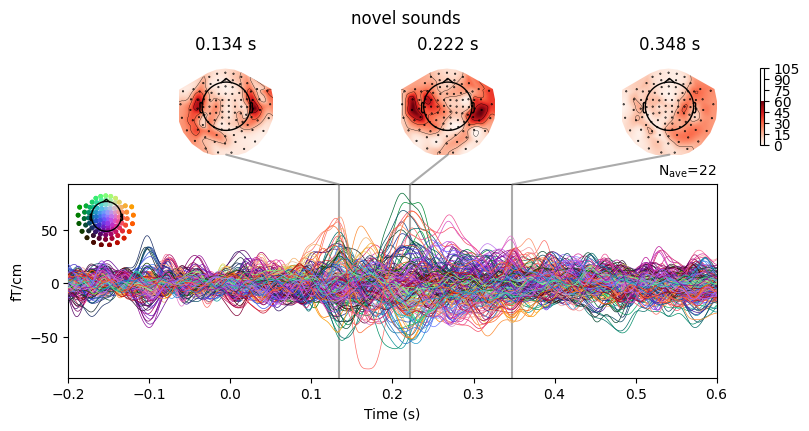

[<Figure size 800x420 with 6 Axes>, <Figure size 800x420 with 6 Axes>]

In [13]:
# 12. Plot ERF for each type of sounds and all the sounds
epochs["auditory"].average().plot_joint(title="all sounds")
epochs["auditory/standard"].average().plot_joint(title="standard sounds")
epochs["auditory/target"].average().plot_joint(title="target sounds")
epochs["auditory/novel"].average().plot_joint(title="novel sounds")

In [14]:
# 13. Calculating significant sensors with permutation test
# pick MEG Gradiometers
event_id = {
    "auditory/standard": 16,
    "auditory/target": 32,
    "auditory/novel": 64,
} #all the types of sounds
picks = mne.pick_types(raw.info, meg='grad', eeg=False, stim=False, eog=False,
                       exclude='bads')  
epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.6, picks=picks,
                    baseline=(None, 0), reject=dict(grad=4000e-13))
data = epochs.get_data()
times = epochs.times
temporal_mask = np.logical_and(0.1 <= times, times <= 0.2) # important: change time window here to see specific duration of interest
data = np.mean(data[:, :, temporal_mask], axis=2)
n_permutations = 50000
T0, p_values, H0 = permutation_t_test(data, n_permutations, n_jobs=None)
significant_sensors = picks[p_values <= 0.05]
significant_sensors_names = [raw.ch_names[k] for k in significant_sensors]
print("Number of significant sensors : %d" % len(significant_sensors))
print("Sensors names : %s" % significant_sensors_names)

Not setting metadata
200 matching events found


Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 2)
4 projection items activated
Using data from preloaded Raw for 200 events and 801 original time points ...
2 bad epochs dropped
Permuting 49999 times...
Number of significant sensors : 25
Sensors names : ['MEG0123', 'MEG0132', 'MEG0212', 'MEG0222', 'MEG0223', 'MEG0232', 'MEG0312', 'MEG0322', 'MEG0323', 'MEG0333', 'MEG0342', 'MEG0343', 'MEG0413', 'MEG0443', 'MEG1223', 'MEG1323', 'MEG1333', 'MEG1423', 'MEG1433', 'MEG1512', 'MEG1523', 'MEG1612', 'MEG2622', 'MEG2623', 'MEG2643']


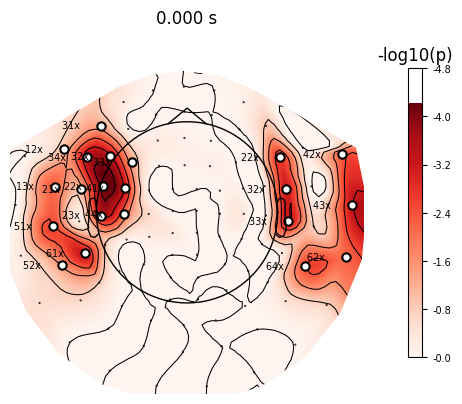

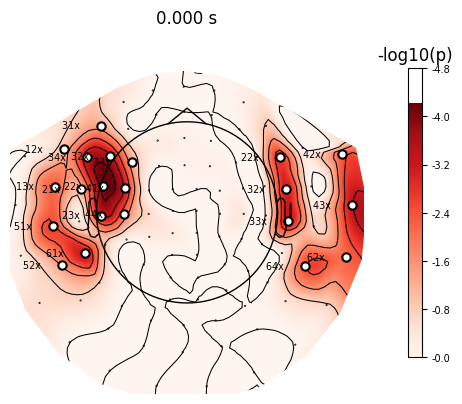

In [15]:
# 14. View the significant sensors on topography
evoked = mne.EvokedArray(-np.log10(p_values)[:, np.newaxis],
                         epochs.info, tmin=0.)
# Extract mask and indices of active sensors in the layout
stats_picks = mne.pick_channels(evoked.ch_names, significant_sensors_names)
mask = p_values[:, np.newaxis] <= 0.05
evoked.plot_topomap(ch_type='grad', times=[0], scalings=1,
                    time_format=None, cmap='Reds', vlim=(0., np.max),
                    units='-log10(p)', cbar_fmt='-%0.1f', mask=mask,
                    size=3, show_names=lambda x: x[4:] + ' ' * 20,
                    time_unit='s')

In [ ]:
# 15. View the significant sensors on surface (with sMRI data)